In [ ]:
!pip install -q nltk tensorflow scikit-learn
import pandas as pd
import numpy as np
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # for lemmatizer if used

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, GRU, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df_fake_gc = pd.read_csv('gossipcop_fake.csv')
df_real_gc = pd.read_csv('gossipcop_real.csv')
df_fake_pf = pd.read_csv('politifact_fake.csv')
df_real_pf = pd.read_csv('politifact_real.csv')

df_fake_gc['label'] = 0
df_fake_pf['label'] = 0
df_real_gc['label'] = 1
df_real_pf['label'] = 1

df = pd.concat([df_fake_gc, df_real_gc, df_fake_pf, df_real_pf], ignore_index=True)
df = df[['title', 'label']].dropna()

In [ ]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered = [w for w in tokens if w.isalnum() and w not in stop_words]
    return ' '.join(filtered)

df['clean_title'] = df['title'].apply(clean_text)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_title'])
sequences = tokenizer.texts_to_sequences(df['clean_title'])
X = pad_sequences(sequences, maxlen=30)
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
input_layer = Input(shape=(30,))
embedding = Embedding(10000, 64)(input_layer)
cnn = Conv1D(64, kernel_size=3, activation='relu')(embedding)
pooling = GlobalMaxPooling1D()(cnn)
gru = GRU(64)(embedding)
concat = Concatenate()([pooling, gru])
dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 64)    │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 64)    │     12,352 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     24,960 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 685,633 (2.62 MB)

 Trainable params: 685,633 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9909 - loss: 0.0299 - val_accuracy: 0.8050 - val_loss: 0.7262
Epoch 2/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9923 - loss: 0.0220 - val_accuracy: 0.8071 - val_loss: 0.8603
Epoch 3/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9931 - loss: 0.0179 - val_accuracy: 0.8109 - val_loss: 0.9669
Epoch 4/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9940 - loss: 0.0125 - val_accuracy: 0.8106 - val_loss: 1.0148
Epoch 5/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9934 - loss: 0.0137 - val_accuracy: 0.8098 - val_loss: 1.1322


In [ ]:
y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1148
           1       0.87      0.88      0.87      3492

    accuracy                           0.81      4640
   macro avg       0.74      0.74      0.74      4640
weighted avg       0.81      0.81      0.81      4640

[[ 687  461]
 [ 422 3070]]


##Accuracy & Loss Graphs

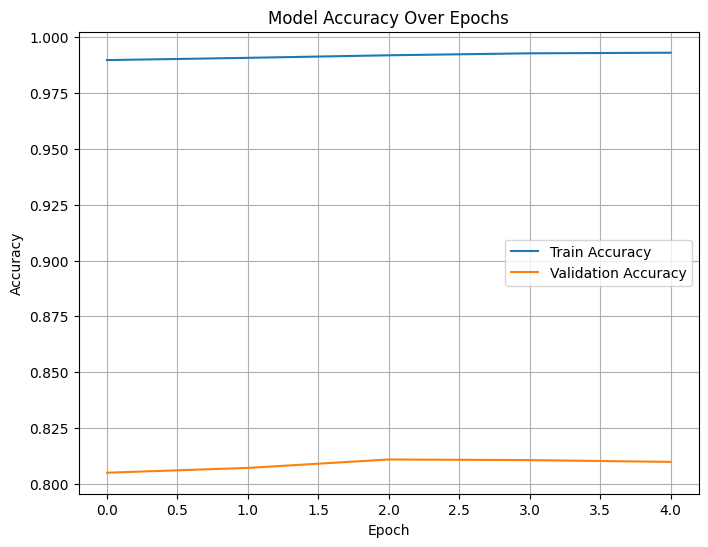

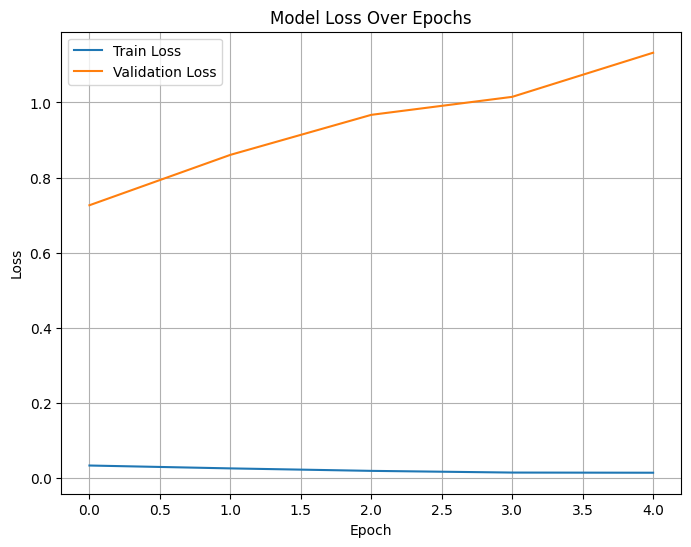

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##Confusion Matrix

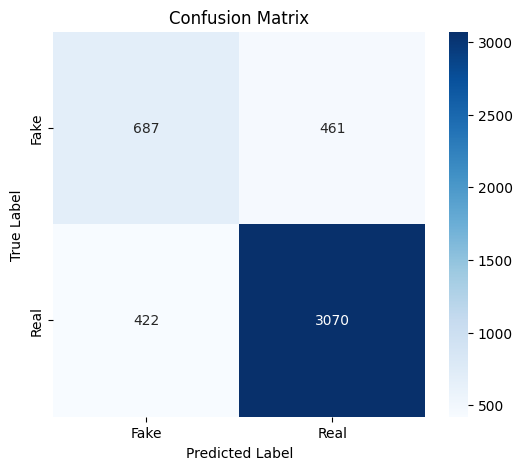

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##ROC Curve & AUC

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


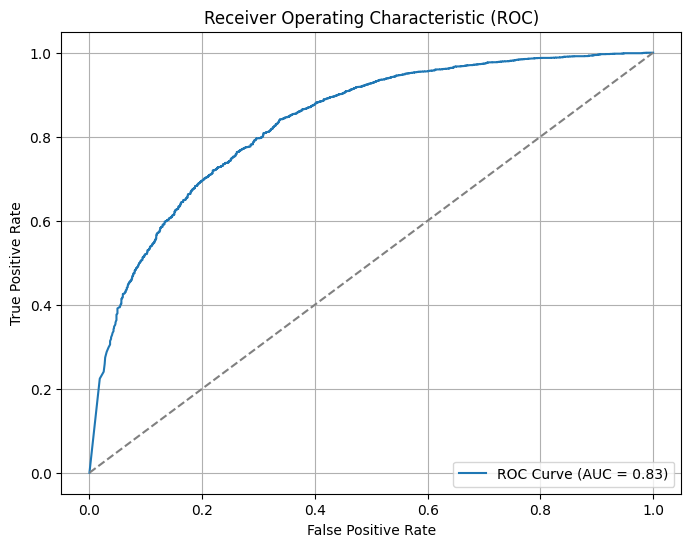

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()